In [75]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for preprocessing
import re
import nltk

## for bag of words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.metrics import classification_report

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("default")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

In [4]:
filepath = '../../data/feedback-effectiveness/train.csv'
train_data = pd.read_csv(filepath)
train_data.shape

(36765, 5)

In [5]:
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate


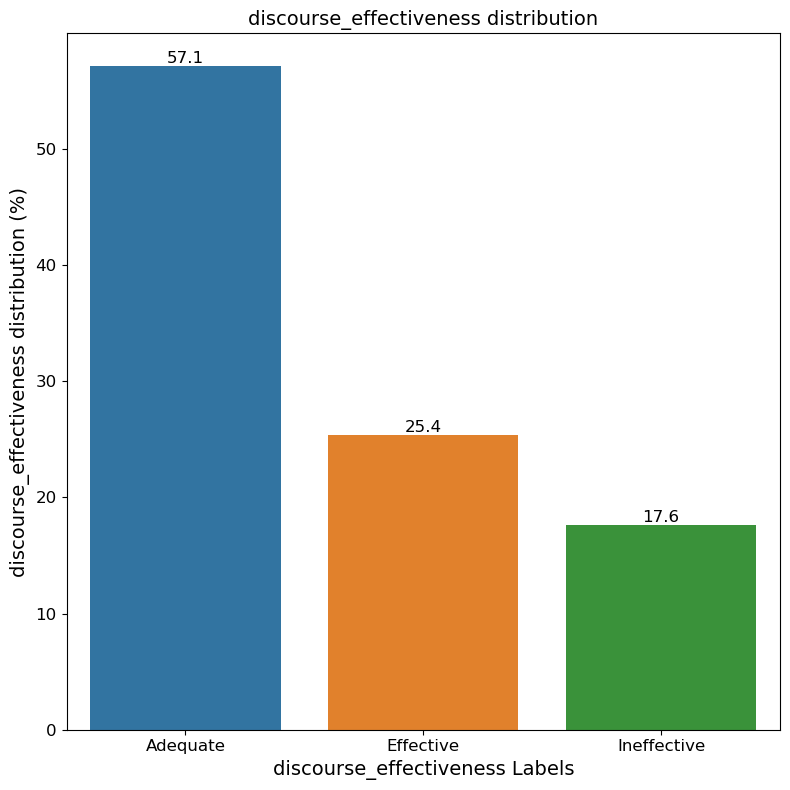

In [6]:
def plot_discourse(train_data):
    percentage_discourse = round(100 * train_data['discourse_effectiveness'].value_counts() / train_data.shape[0], 1)
    plt.figure(figsize=(8,8))

    plt.title('discourse_effectiveness distribution', fontsize = 14)
    plt.xlabel('discourse_effectiveness Labels', fontsize = 14)
    plt.ylabel('discourse_effectiveness distribution (%)', fontsize = 14)
    ax= sns.barplot(x =percentage_discourse.index, y =percentage_discourse.values)
    for i in ax.containers:
        ax.bar_label(i, fontsize = 12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout();
plot_discourse(train_data)

In [7]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    """
    ## clean (convert to lowercase and remove punctuations and   
    #characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("english")


In [9]:
train_data["discourse_text_clean"] = train_data["discourse_text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
train_data.head()


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_text_clean
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,hi im isaac im going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,perspective think face natural landform dont think life mar next paragraph ill talking think natural landform
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate,think face natural landform life mar descovered yet
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate,life mar would know reason think natural landform nobody live mar order create figure say paragraph 9 easy target cydonia saying easy know natural landform point theyre saying probably natural landform
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate,people thought face formed alieans thought life mar


In [10]:
def get_label_idx_map(df, colname):
    label_to_idx = {}
    for i, j in enumerate(df[colname].unique()):
        label_to_idx[j] = i
    print(label_to_idx)
    return label_to_idx

discourse_effectiveness_map = get_label_idx_map(train_data, "discourse_effectiveness")
train_data['discourse_effectiveness_cat']= train_data['discourse_effectiveness'].map(discourse_effectiveness_map)

{'Adequate': 0, 'Ineffective': 1, 'Effective': 2}


In [11]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(train_data, test_size=0.3, random_state=42, stratify=train_data['discourse_effectiveness'])
## get target
y_train = dtf_train["discourse_effectiveness"].values
y_test = dtf_test["discourse_effectiveness"].values

In [12]:
train_data['discourse_text_len'] = train_data.apply(lambda x: len(x['discourse_text_clean']), axis =1)

In [13]:
from collections import Counter
train_counts = Counter(y_train)
test_counts = Counter(y_test)
print(train_counts,'\n', test_counts)

Counter({'Adequate': 14684, 'Effective': 6528, 'Ineffective': 4523}) 
 Counter({'Adequate': 6293, 'Effective': 2798, 'Ineffective': 1939})


## Countvectorizer vs TFIDFVectorizer

In [14]:
## Count (classic BoW)
cnt_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

corpus = dtf_train['discourse_text_clean']
cnt_vectorizer.fit(corpus)
X_train = cnt_vectorizer.transform(corpus)
dic_vocabulary_cnt = cnt_vectorizer.vocabulary_

CountVectorizer(max_features=10000, ngram_range=(1, 2))

In [15]:
# dic_vocabulary_cnt

In [16]:
## Tf-Idf (advanced variant of BoW)
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))


tfidf_vectorizer.fit(corpus)
X_train = tfidf_vectorizer.transform(corpus)
dic_vocabulary_tfidf = tfidf_vectorizer.vocabulary_

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [17]:
len(dic_vocabulary_tfidf)

10000

In [18]:
word = "college"
print(dic_vocabulary_cnt[word],dic_vocabulary_tfidf[word])

1670 1670


**reduce the matrix dimensionality** in order to reduce the dimensionality of our matrix ! **[Feature matrix shape: Number of documents x Length of vocabulary ]** we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:

1) treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
2) perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
3) keep only the features with a certain p-value from the Chi-Square test.

In [19]:
from sklearn import feature_selection

y = dtf_train["discourse_effectiveness_cat"]
X_names= tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p= feature_selection.chi2(X_train, y==cat)
    df_features = df_features.append(pd.DataFrame({"features":X_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], ascending = [True, False])
    df_features = df_features[df_features["score"] > p_value_limit]

X_names = list(df_features["features"].unique())
len(X_names)

/var/folders/yv/qx_vtmvd721bhgw60zgg83m00000gn/T/ipykernel_29947/2161626807.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame({"features":X_names, "score":1-p, "y":cat}))
/var/folders/yv/qx_vtmvd721bhgw60zgg83m00000gn/T/ipykernel_29947/2161626807.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame({"features":X_names, "score":1-p, "y":cat}))
/var/folders/yv/qx_vtmvd721bhgw60zgg83m00000gn/T/ipykernel_29947/2161626807.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame({"features":X_names, "score":1-p, "y":cat}))


1329

In [20]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
tfidf_vectorizer.fit(corpus)
X_train = tfidf_vectorizer.transform(corpus)
dic_vocabulary_tfidf = tfidf_vectorizer.vocabulary_
len(dic_vocabulary_tfidf)

TfidfVectorizer(vocabulary=['project', 'landform', 'learning', 'student',
                            'natural', 'knowledge', 'natural landform',
                            'assignment', 'education', 'decision',
                            'distance learning', 'summer', 'beneficial',
                            'given', 'experience', 'however', 'phone', 'year',
                            'ability', 'school year', 'distance', 'allows',
                            'mesa', 'issue', 'interest', 'allows student',
                            'provide', 'curriculum', 'throughout', 'complete', ...])

1329

In [21]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(df_features[df_features["y"]==cat]))
    print("  . top features:", ",".join(
df_features[df_features["y"]==cat]["features"].values[:10]))
    print(" ")

# 0:
  . selected features: 269
  . top features: project,landform,learning,student,natural,knowledge,natural landform,assignment,education,decision
 
# 1:
  . selected features: 502
  . top features: student,venus,project,president,planet,consists,elector,mona,lisa,mona lisa
 
# 2:
  . selected features: 934
  . top features: learning,project,student,summer,assignment,teacher,education,distance learning,alien,knowledge
 


## Modelling

### Naive Bayes Algorithm

In [22]:
classifier = naive_bayes.MultinomialNB()


In [23]:
final_pipieline = pipeline.Pipeline([("vectorizer", tfidf_vectorizer),
                                     ("classifier", classifier)])

##train classifier
final_pipieline["classifier"].fit(X_train,y_train)

## Test 

X_test =dtf_test['discourse_text_clean'].values
predicted = final_pipieline.predict(X_test)
predicted_prob = final_pipieline.predict_proba(X_test)

MultinomialNB()

In [24]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predicted)
accuracy

0.6266545784224842

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

    Adequate       0.63      0.87      0.73      6293
   Effective       0.62      0.44      0.52      2798
 Ineffective       0.57      0.12      0.19      1939

    accuracy                           0.63     11030
   macro avg       0.61      0.47      0.48     11030
weighted avg       0.62      0.63      0.58     11030



<Axes: >

[Text(0.5, 23.52222222222222, 'Pred'),
 Text(50.722222222222214, 0.5, 'True'),
 [Text(0.5, 0, 'Adequate'),
  Text(1.5, 0, 'Effective'),
  Text(2.5, 0, 'Ineffective')],
 [Text(0, 0.5, 'Adequate'),
  Text(0, 1.5, 'Effective'),
  Text(0, 2.5, 'Ineffective')],
 Text(0.5, 1.0, 'Confusion matrix')]

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Adequate'),
  Text(0, 1.5, 'Effective'),
  Text(0, 2.5, 'Ineffective')])

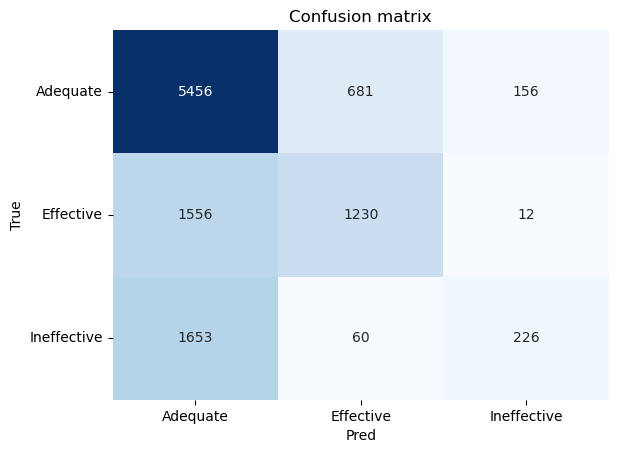

In [26]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


[(-0.05, 1.0),
 (0.0, 1.05),
 Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate (Recall)'),
 Text(0.5, 1.0, 'Receiver operating characteristic')]

[(0.0, 1.05),
 (0.0, 1.05),
 Text(0.5, 0, 'Recall'),
 Text(0, 0.5, 'Precision'),
 Text(0.5, 1.0, 'Precision-Recall curve')]

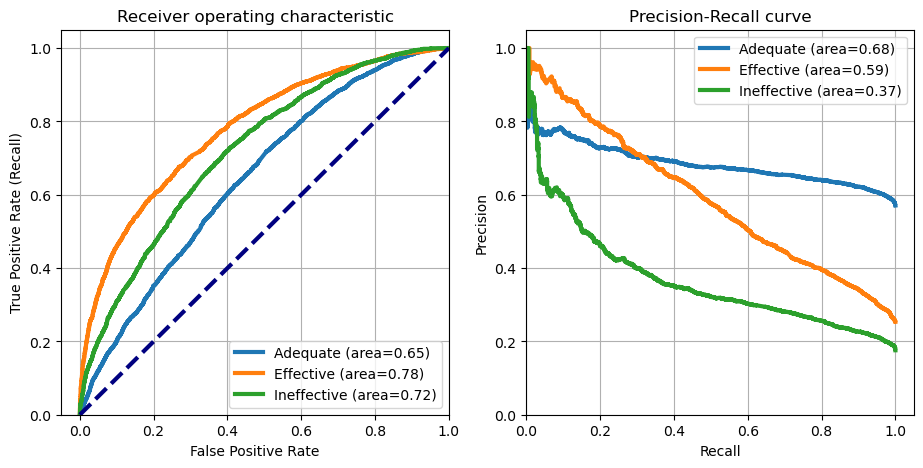

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))


## Plot ROC
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))

ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [28]:
i =5

text_instance = dtf_test['discourse_text_clean'].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(text_instance, final_pipieline.predict_proba, num_features=3)
explained.show_in_notebook(text=text_instance, predict_proba=False)

True: Ineffective --> Pred: Adequate | Prob: 0.69


/Users/shringa/miniconda/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/Users/shringa/miniconda/lib/python3.10/site-packages/lime/explanation.py:251: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/shringa/miniconda/lib/python3.10/site-packages/lime/bundle.js' mode='r' encoding='utf8'>
  encoding="utf8").read()


## Word Embedding
Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing before or after another. To put it another way, words of the same context usually appear together in the corpus, so they will be close in the vector space as well.

I’m going to use the first model of this family: **Google’s Word2Vec (2013)**. Other popular Word Embedding models are **Stanford’s GloVe (2014)** and Facebook’s **FastText (2016)**.

**Word2Vec** produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space. That can be done using 2 different approaches: starting from a single word to predict its context (Skip-gram) or starting from the context to predict a word (Continuous Bag-of-Words).

In [29]:
nlp = gensim_api.load("word2vec-google-news-300")

In [30]:
nlp.word_vec

<bound method KeyedVectors.word_vec of <gensim.models.keyedvectors.KeyedVectors object at 0x28806d390>>

In [31]:
corpus = dtf_train['discourse_text_clean']

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)


In [32]:
lst_corpus[0] 

['electoral',
 'college',
 'good',
 'alot',
 'work',
 'find',
 'win',
 'president',
 'vice',
 'president',
 'seat']

In [33]:
## fit w2v

from gensim.models import FastText
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=128, window=5, min_count=1, sg=1)
#nlp = FastText(lst_corpus, vector_size=32, window=8, min_count=1)

In [34]:
nlp.wv.most_similar("college")

[('collage', 0.890872061252594),
 ('electoral', 0.8177504539489746),
 ('collge', 0.8057419657707214),
 ('electorial', 0.8014845848083496),
 ('abolished', 0.7913062572479248),
 ('outdated', 0.7881190180778503),
 ('elctoral', 0.7803226709365845),
 ('colledge', 0.771268367767334),
 ('irrational', 0.7681477069854736),
 ('colllege', 0.7641584277153015)]

In [35]:
word = 'electoral'
len(nlp.wv[word])

128

/var/folders/yv/qx_vtmvd721bhgw60zgg83m00000gn/T/ipykernel_29947/3219416896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_["input"].iloc[0:1] = 1


[Text(0.5, 0, ''),
 Text(0.5, 0.5, ''),
 Text(0.5, 0, ''),
 [Text(-100.0, 0, ''),
  Text(-75.0, 0, ''),
  Text(-50.0, 0, ''),
  Text(-25.0, 0, ''),
  Text(0.0, 0, ''),
  Text(25.0, 0, ''),
  Text(50.0, 0, ''),
  Text(75.0, 0, ''),
  Text(100.0, 0, ''),
  Text(125.0, 0, '')],
 [Text(-150.0, 0, ''),
  Text(-100.0, 0, ''),
  Text(-50.0, 0, ''),
  Text(0.0, 0, ''),
  Text(50.0, 0, ''),
  Text(100.0, 0, ''),
  Text(150.0, 0, ''),
  Text(200.0, 0, '')],
 [Text(-150.0, 0, ''),
  Text(-100.0, 0, ''),
  Text(-50.0, 0, ''),
  Text(0.0, 0, ''),
  Text(50.0, 0, ''),
  Text(100.0, 0, ''),
  Text(150.0, 0, '')]]

Text(-57.5466194152832, 138.1605987548828, 'electoral')

Text(-8.93354320526123, -108.615966796875, 'electorial')

Text(-59.1373291015625, -68.597900390625, 'elctoral')

Text(-82.49349975585938, 8.103713989257812, 'eletoral')

Text(-23.597265243530273, 83.87922668457031, 'college')

Text(-84.85529327392578, -86.33058166503906, 'abolished')

Text(34.941673278808594, 105.0642318725586, 'collage')

Text(-27.677854537963867, -20.895347595214844, 'electroal')

Text(42.815128326416016, -50.35112762451172, 'outdated')

Text(3.3471362590789795, 41.47871780395508, 'electrol')

Text(-67.84634399414062, 32.53693389892578, 'ellectoral')

Text(-49.26467514038086, -27.80169105529785, 'collge')

Text(36.471492767333984, -55.7188835144043, 'elecoral')

Text(-5.486943244934082, -16.610078811645508, 'irrational')

Text(27.418458938598633, 1.1147325038909912, 'voteing')

Text(68.7116928100586, -125.70357513427734, 'presidency')

Text(101.05733489990234, 6.25678825378418, 'electorals')

Text(63.52748489379883, 77.18659973144531, 'electoal')

Text(51.05599594116211, -6.908883094787598, 'decison')

Text(68.278564453125, 68.93195343017578, 'electral')

Text(-1.488970398902893, 78.34376525878906, 'elecotral')

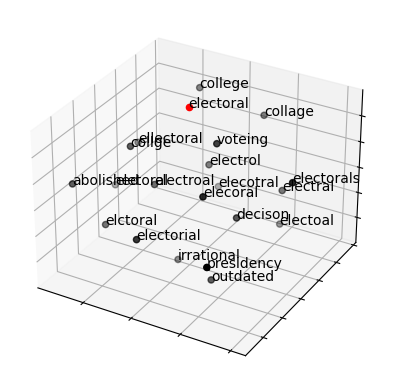

In [36]:
word = 'electoral'
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity =10, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")

ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")

ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

## Word Embedding

The word vectors can be used in a neural network as weights. This is how:

1) First, transform the corpus into padded sequences of word ids to get a feature matrix.
2) Then, create an embedding matrix so that the vector of the word with id N is located at the Nth row.
3) Finally, build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.  

Let’s start with the **Feature Engineering** by transforming the same preprocessed corpus (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras:

In [37]:
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_text_clean,discourse_effectiveness_cat,discourse_text_len
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,hi im isaac im going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform,0,173
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,perspective think face natural landform dont think life mar next paragraph ill talking think natural landform,0,109


In [38]:
## Tokenize text
tokenizer_emd = kprocessing.text.Tokenizer(lower = True, split =' ', oov_token = "UNK", filters ='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer_emd.fit_on_texts(lst_corpus)
dic_vocabulary  = tokenizer_emd.word_index

## Create Sequence
lst_text2seq = tokenizer_emd.texts_to_sequences(lst_corpus)

## Padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen = 50, padding="post", truncating ="post")

In [39]:
train_data['discourse_text_len'].describe()

count    36765.000000
mean       151.729226
std        165.008925
min          0.000000
25%         52.000000
50%         93.000000
75%        190.000000
max       2515.000000
Name: discourse_text_len, dtype: float64

In [40]:
# dic_vocabulary.keys()

In [41]:
from numpy import mean
mean_val=[]
for i in lst_text2seq:
    mean_val.append(len(i))
    
mean(mean_val)

22.094307363512726

In [42]:
X_train.shape

(25735, 50)

In [43]:
y_train[:10]

array(['Ineffective', 'Effective', 'Adequate', 'Adequate', 'Adequate',
       'Effective', 'Ineffective', 'Adequate', 'Adequate', 'Effective'],
      dtype=object)

<Axes: >

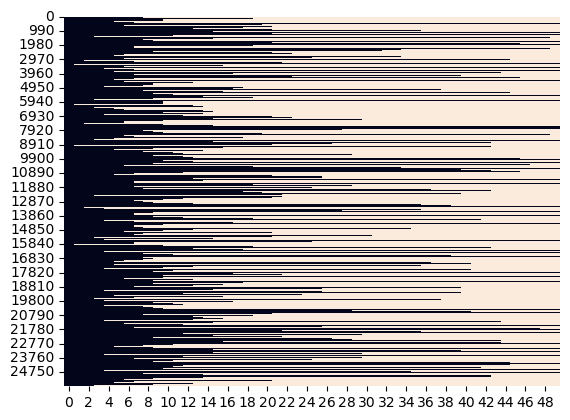

In [44]:
sns.heatmap(X_train==0, vmin=0,vmax=1,cbar= False)
plt.show()

In [45]:
i =0

## list of text
len_txt = len(train_data['discourse_text_clean'].iloc[i].split())
print("from: ", train_data["discourse_text_clean"].iloc[i], "| len:", len_txt)
print("from: ", lst_corpus[i], "| len:", len_txt)

## sequence of tokens
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary
print("check: ", train_data["discourse_text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[train_data["discourse_text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  hi im isaac im going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform | len: 30
from:  ['electoral', 'college', 'good', 'alot', 'work', 'find', 'win', 'president', 'vice', 'president', 'seat'] | len: 30
to:  [   7    8   35  401   32  133  225   20  563   20 1397    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] | len: 50
check:  hi  -- idx in vocabulary --> 3585
vocabulary:  {'UNK': 1, 'student': 2, 'people': 3, 'would': 4, 'vote': 5} ... (padding element, 0)


### Applying the same for test data set

In [46]:
corpus = dtf_test["discourse_text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer_emd.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=50,
             padding="post", truncating="post")

<Axes: >

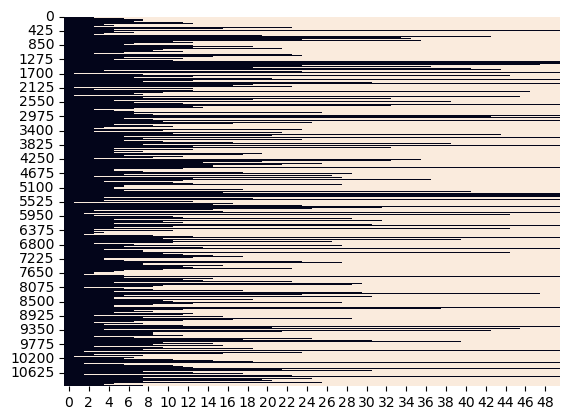

In [47]:
sns.heatmap(X_test==0, vmin=0,vmax=1,cbar= False)
plt.show()

In [48]:
nlp.wv.vectors.shape

(22766, 128)

In [49]:
 # for word, idx in dic_vocabulary.items():
 #    print(word,idx)

In [50]:
def initialize_embedding_w2v(word_vectors: np.ndarray, vocab: dict)-> np.ndarray:
    n_dim = word_vectors.wv.vectors.shape[1]
    n_words = word_vectors.wv.vectors.shape[0]
    embeddings = np.zeros((len(vocab)+1, n_dim))
    for word, idx in vocab.items():
        try:
            embeddings[idx] = word_vectors.wv[word]
        except Exception as error:
            pass# print(error)
    assert embeddings.shape[1]== n_dim
    return embeddings

In [51]:
embeddings = initialize_embedding_w2v(nlp,dic_vocabulary)

In [52]:
word = "electrol"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

dic[word]: 3282 |idx
embeddings[idx]: (128,) |vector


In [53]:
assert all(nlp.wv[word] == embeddings[dic_vocabulary[word]])

## Building a Deep Learning Model

In [54]:
import gc
import os
gc.collect()

85

In [55]:
def output_emd(class_labels):
    dic_y_mapping = {n:label for n,label in enumerate(np.unique(class_labels))}
    inverse_dic = {v:k for k,v in dic_y_mapping.items()}
    class_labels = np.array([inverse_dic[y] for y in class_labels])
    return to_categorical(class_labels, num_classes=3,dtype='int32')
    

In [56]:
## encode y_train
y_train = output_emd(y_train)
## encode y_text
y_test = output_emd(y_test)

In [57]:
K.clear_session()


from tensorflow.keras import regularizers

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1, monitor="val_categorical_accuracy")


## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(50,))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0], output_dim=128, weights=[embeddings], input_length=50, trainable=False)(x_in)

# ## apply attention
x = attention_layer(x, neurons=50)
# ## 2 layers of bidirectional lstm
# x = layers.Bidirectional(layers.LSTM(units=50,return_sequences=True))(x)
# # x = layers.Bidirectional(layers.LSTM(units=16, dropout=0.2))(x)
x= layers.GlobalAveragePooling1D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.4)(x)
# ## final dense layers
y_out = layers.Dense(3, activation='softmax')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])


Metal device set to: Apple M2


In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2914304     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 128, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 128, 50)      2550        ['permute[0][0]']                
                                                                                              

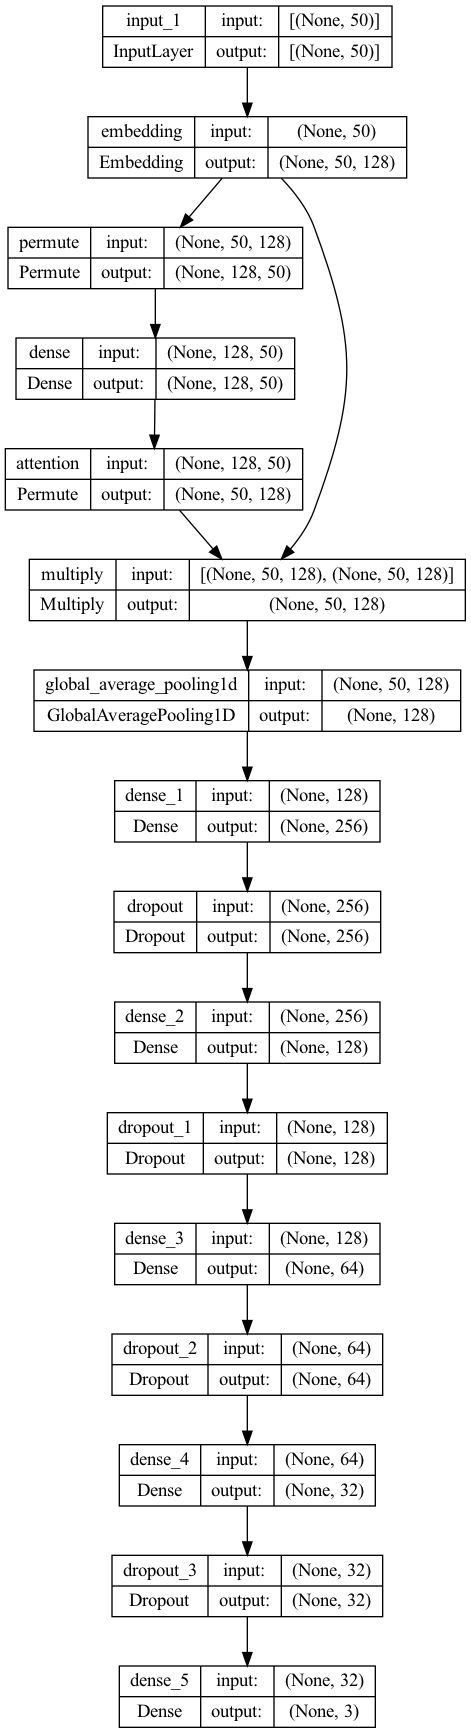

In [59]:
plot_model(model,show_shapes=True)

In [60]:
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, shuffle=True, verbose=2, validation_split=0.15, callbacks=[cp_callback])

Epoch 1/100


2023-05-04 18:52:38.021917: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 1: val_categorical_accuracy improved from -inf to 0.57343, saving model to training_1/cp.ckpt
86/86 - 2s - loss: 1.0067 - categorical_accuracy: 0.5662 - val_loss: 0.9556 - val_categorical_accuracy: 0.5734 - 2s/epoch - 26ms/step
Epoch 2/100

Epoch 2: val_categorical_accuracy improved from 0.57343 to 0.61461, saving model to training_1/cp.ckpt
86/86 - 1s - loss: 0.9538 - categorical_accuracy: 0.5928 - val_loss: 0.9146 - val_categorical_accuracy: 0.6146 - 1s/epoch - 16ms/step
Epoch 3/100

Epoch 3: val_categorical_accuracy improved from 0.61461 to 0.62031, saving model to training_1/cp.ckpt
86/86 - 1s - loss: 0.9240 - categorical_accuracy: 0.6113 - val_loss: 0.8815 - val_categorical_accuracy: 0.6203 - 1s/epoch - 17ms/step
Epoch 4/100

Epoch 4: val_categorical_accuracy improved from 0.62031 to 0.62238, saving model to training_1/cp.ckpt
86/86 - 1s - loss: 0.8935 - categorical_accuracy: 0.6192 - val_loss: 0.8699 - val_categorical_accuracy: 0.6224 - 1s/epoch - 16ms/step
Epoch 5/100

Ep

In [61]:
model.load_weights("training_1/cp.ckpt")

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

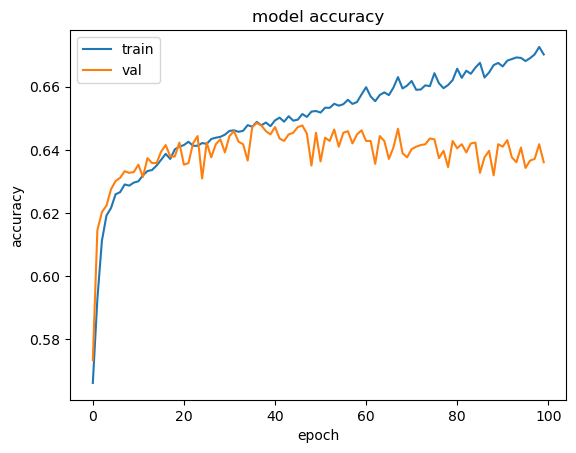

In [62]:
# plot loss and accuracy
plt.plot(training.history["categorical_accuracy"])
plt.plot(training.history["val_categorical_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

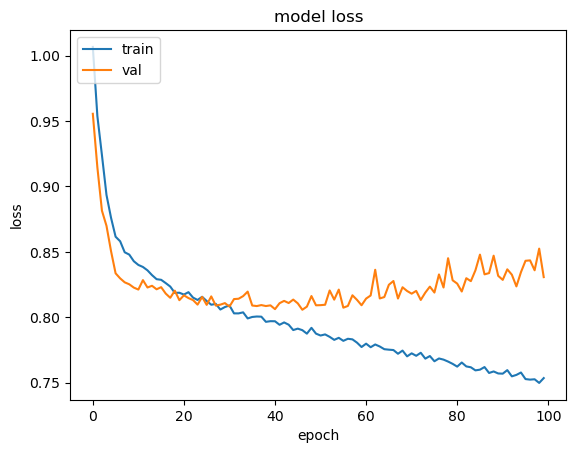

In [63]:
training.history.keys()
plt.plot(training.history["loss"])
plt.plot(training.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
## test
predicted_prob = model.predict(X_test)

345/345 [==============================] - 1s 3ms/step


In [65]:
pd.DataFrame(zip(y_test, predicted_prob, predicted_prob.argmax(1)), columns=["true_label", "predicted_prob","predicted_label"]).head(10)

,true_label,predicted_prob,predicted_label
0,"[0, 1, 0]","[0.24636811, 0.7290062, 0.024625659]",1
1,"[0, 1, 0]","[0.16966724, 0.82302684, 0.0073058954]",1
2,"[0, 0, 1]","[0.63724184, 0.12316051, 0.23959763]",0
3,"[0, 1, 0]","[0.37527087, 0.5848089, 0.039920256]",1
4,"[1, 0, 0]","[0.4568248, 0.050647076, 0.49252808]",2
5,"[0, 0, 1]","[0.70501703, 0.038435403, 0.25654754]",0
6,"[1, 0, 0]","[0.6639324, 0.1316867, 0.20438088]",0
7,"[0, 0, 1]","[0.6842812, 0.02038731, 0.2953316]",0
8,"[1, 0, 0]","[0.13693425, 0.8572254, 0.0058403327]",1
9,"[0, 1, 0]","[0.5136498, 0.37116697, 0.11518323]",0


In [66]:
predicted = np.zeros_like(predicted_prob)
predicted[np.arange(len(predicted_prob)), predicted_prob.argmax(1)] = 1

['Adequate' 'Effective' 'Ineffective']


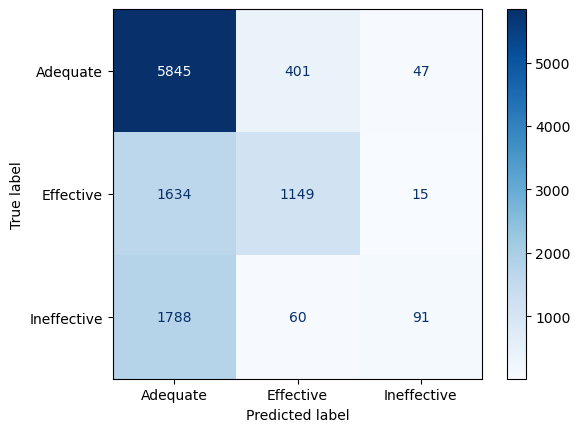

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

print(classes)
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), predicted.argmax(axis=1), display_labels=classes, cmap=plt.cm.Blues)

In [68]:

metrics.accuracy_score(y_test, predicted)

0.64233907524932

In [76]:
print(classification_report(y_test.argmax(axis=1), predicted.argmax(axis=1), target_names = classes))

              precision    recall  f1-score   support

    Adequate       0.63      0.93      0.75      6293
   Effective       0.71      0.41      0.52      2798
 Ineffective       0.59      0.05      0.09      1939

    accuracy                           0.64     11030
   macro avg       0.65      0.46      0.45     11030
weighted avg       0.65      0.64      0.58     11030



## Explainable

In [69]:
# dtf_test.head(1)

In [70]:
# for layer in model.layers:
#     print(layer.name)

In [71]:
# ## select observation
# i = 50
# txt_instance = dtf_test["discourse_text_clean"].iloc[i]

# ## check true value and predicted value
# print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

# ## show explanation
# # get attention weights
# layer = [layer for layer in model.layers if "attention" in layer.name][0]
# func = K.function([model.input], [layer.output])
# weights = func(X_train)[0]
# weights = np.mean(weights, axis=2).flatten()

# ### rescale weights, remove null vector, map word-weight
# weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
# weights = [weights[n] for n,idx in enumerate(X_train[0]) if idx != 0]
# dic_word_weigth = {word:weights[n] for n,word in enumerate(lst_corpus[0]) if word in tokenizer_emd.word_index.keys()}

In [72]:
# for n,word in enumerate(lst_corpus[0]):
#     if word in tokenizer_emd.word_index.keys():
#         print(weights[n])

In [73]:
# for n,idx in enumerate(X_train[0]):
#     print(n)